<a href="https://colab.research.google.com/github/KOPULEGAM/House_Price_Predictor/blob/main/Another_copy_of_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3

## Download data

In [ ]:
!git clone https://github.com/emanhamed/Houses-dataset.git

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165 (from 1)
Receiving objects: 100% (2166/2166), 176.26 MiB | 13.83 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (2144/2144), done.


In [ ]:
%cd Houses-dataset/Houses Dataset

/content/Houses-dataset/Houses Dataset


## Load the dataset

In [ ]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate

#### Functions

In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

### Text Data

In [ ]:
filename_read = os.path.join("HousesInfo.txt")

cols=["Bedrooms","Bathrooms","area","zipcode","price"]

text_df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)

In [ ]:
text_df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [ ]:
text_df.shape

(535, 5)

### Image Data

In [ ]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob(str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path)

In [ ]:
new_images

['1_bathroom.jpg',
 '2_bathroom.jpg',
 '3_bathroom.jpg',
 '4_bathroom.jpg',
 '5_bathroom.jpg',
 '6_bathroom.jpg',
 '7_bathroom.jpg',
 '8_bathroom.jpg',
 '9_bathroom.jpg',
 '10_bathroom.jpg',
 '11_bathroom.jpg',
 '12_bathroom.jpg',
 '13_bathroom.jpg',
 '14_bathroom.jpg',
 '15_bathroom.jpg',
 '16_bathroom.jpg',
 '17_bathroom.jpg',
 '18_bathroom.jpg',
 '19_bathroom.jpg',
 '20_bathroom.jpg',
 '21_bathroom.jpg',
 '22_bathroom.jpg',
 '23_bathroom.jpg',
 '24_bathroom.jpg',
 '25_bathroom.jpg',
 '26_bathroom.jpg',
 '27_bathroom.jpg',
 '28_bathroom.jpg',
 '29_bathroom.jpg',
 '30_bathroom.jpg',
 '31_bathroom.jpg',
 '32_bathroom.jpg',
 '33_bathroom.jpg',
 '34_bathroom.jpg',
 '35_bathroom.jpg',
 '36_bathroom.jpg',
 '37_bathroom.jpg',
 '38_bathroom.jpg',
 '39_bathroom.jpg',
 '40_bathroom.jpg',
 '41_bathroom.jpg',
 '42_bathroom.jpg',
 '43_bathroom.jpg',
 '44_bathroom.jpg',
 '45_bathroom.jpg',
 '46_bathroom.jpg',
 '47_bathroom.jpg',
 '48_bathroom.jpg',
 '49_bathroom.jpg',
 '50_bathroom.jpg',
 '51_bath

In [ ]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [ ]:
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob(str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path)

In [ ]:
img['bedroom_img']=bedroom_images

In [ ]:
frontal_images = []
for number in range(1, 536):
    for path in glob.glob(str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path)

In [ ]:
img['frontal_img']=frontal_images

In [ ]:
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob(str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path)

In [ ]:
img['kitchen_img']=kitchen_images

In [ ]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,1_bathroom.jpg,1_bedroom.jpg,1_frontal.jpg,1_kitchen.jpg
1,2_bathroom.jpg,2_bedroom.jpg,2_frontal.jpg,2_kitchen.jpg
2,3_bathroom.jpg,3_bedroom.jpg,3_frontal.jpg,3_kitchen.jpg
3,4_bathroom.jpg,4_bedroom.jpg,4_frontal.jpg,4_kitchen.jpg
4,5_bathroom.jpg,5_bedroom.jpg,5_frontal.jpg,5_kitchen.jpg


In [ ]:
img.shape

(535, 4)

# Merge the data
to drop the outliers equivalent to the each data of the row, we need to merge

Concatenate houses images into one image for each house

In [ ]:
df = pd.concat([text_df, img], axis=1)

In [ ]:
print(df.shape)
df.head()

(535, 9)


,Bedrooms,Bathrooms,area,zipcode,price,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,4,4.0,4053,85255,869500,1_bathroom.jpg,1_bedroom.jpg,1_frontal.jpg,1_kitchen.jpg
1,4,3.0,3343,36372,865200,2_bathroom.jpg,2_bedroom.jpg,2_frontal.jpg,2_kitchen.jpg
2,3,4.0,3923,85266,889000,3_bathroom.jpg,3_bedroom.jpg,3_frontal.jpg,3_kitchen.jpg
3,5,5.0,4022,85262,910000,4_bathroom.jpg,4_bedroom.jpg,4_frontal.jpg,4_kitchen.jpg
4,3,4.0,4116,85266,971226,5_bathroom.jpg,5_bedroom.jpg,5_frontal.jpg,5_kitchen.jpg


# remove outliers

In [ ]:
encode_numeric_zscore(df, 'price')

In [ ]:
df.head()

,Bedrooms,Bathrooms,area,zipcode,price,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,4,4.0,4053,85255,0.550340,1_bathroom.jpg,1_bedroom.jpg,1_frontal.jpg,1_kitchen.jpg
1,4,3.0,3343,36372,0.541892,2_bathroom.jpg,2_bedroom.jpg,2_frontal.jpg,2_kitchen.jpg
2,3,4.0,3923,85266,0.588648,3_bathroom.jpg,3_bedroom.jpg,3_frontal.jpg,3_kitchen.jpg
3,5,5.0,4022,85262,0.629903,4_bathroom.jpg,4_bedroom.jpg,4_frontal.jpg,4_kitchen.jpg
4,3,4.0,4116,85266,0.750184,5_bathroom.jpg,5_bedroom.jpg,5_frontal.jpg,5_kitchen.jpg


In [ ]:
remove_outliers(df, 'price', df['price'].std())

In [ ]:
df.shape

(451, 9)

In [ ]:
df.head()
#Categorical data: Bedrooms, Bathrooms, zipcode
#Numeric data: area, price

,Bedrooms,Bathrooms,area,zipcode,price,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,4,4.0,4053,85255,0.550340,1_bathroom.jpg,1_bedroom.jpg,1_frontal.jpg,1_kitchen.jpg
1,4,3.0,3343,36372,0.541892,2_bathroom.jpg,2_bedroom.jpg,2_frontal.jpg,2_kitchen.jpg
2,3,4.0,3923,85266,0.588648,3_bathroom.jpg,3_bedroom.jpg,3_frontal.jpg,3_kitchen.jpg
3,5,5.0,4022,85262,0.629903,4_bathroom.jpg,4_bedroom.jpg,4_frontal.jpg,4_kitchen.jpg
4,3,4.0,4116,85266,0.750184,5_bathroom.jpg,5_bedroom.jpg,5_frontal.jpg,5_kitchen.jpg


now we can split img data and txt data

## Data Encoding

In [ ]:
df.shape

(451, 9)

#### Drop img columns

In [ ]:
img = df[['bathroom_img', 'bedroom_img', 'frontal_img', 'kitchen_img']]

print(img.shape)
img.head()

(451, 4)


,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,1_bathroom.jpg,1_bedroom.jpg,1_frontal.jpg,1_kitchen.jpg
1,2_bathroom.jpg,2_bedroom.jpg,2_frontal.jpg,2_kitchen.jpg
2,3_bathroom.jpg,3_bedroom.jpg,3_frontal.jpg,3_kitchen.jpg
3,4_bathroom.jpg,4_bedroom.jpg,4_frontal.jpg,4_kitchen.jpg
4,5_bathroom.jpg,5_bedroom.jpg,5_frontal.jpg,5_kitchen.jpg


In [ ]:
df = df.drop(columns = ['bathroom_img', 'bedroom_img', 'frontal_img', 'kitchen_img'])
text_df = df

In [ ]:
print(text_df.shape)
text_df.head()

(451, 5)


,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,0.550340
1,4,3.0,3343,36372,0.541892
2,3,4.0,3923,85266,0.588648
3,5,5.0,4022,85262,0.629903
4,3,4.0,4116,85266,0.750184


### Encode each columns

In [ ]:
encode_numeric_zscore(text_df, 'area')
encode_text_dummy(text_df, 'Bedrooms')
encode_text_dummy(text_df, 'Bathrooms')
encode_text_dummy(text_df, 'zipcode')

In [ ]:
print(text_df.shape)
text_df.head()

(451, 66)


,area,price,Bedrooms-1,Bedrooms-2,Bedrooms-3,Bedrooms-4,Bedrooms-5,Bedrooms-6,Bedrooms-7,Bedrooms-8,...,zipcode-93510,zipcode-93720,zipcode-94501,zipcode-94531,zipcode-94565,zipcode-94568,zipcode-95008,zipcode-95220,zipcode-96019,zipcode-98021
0,1.570881,0.550340,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.942283,0.541892,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.455785,0.588648,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.543435,0.629903,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.626658,0.750184,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Truncate the image

In [ ]:
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))

            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))

            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))

            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))

            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)

            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]


            images_output.append(outputImage)


In [ ]:
#Display all the truncated image sets
# from matplotlib import pyplot as plt

# for i in images_output:
#      plt.figure(figsize=(8,8))
#      plt.imshow(i, interpolation='nearest')
#      plt.show()

### Convert each pixel of the image to numeric value
to make it CNN friendly

In [ ]:
img_arr = np.asarray(images_output)

In [ ]:
img_arr.shape

(451, 128, 128, 3)

# Data Split -> Trainning/Testing

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test, img_train, img_test = train_test_split(df, img_arr, test_size=0.25, random_state=42)
df_train.shape, df_test.shape, img_train.shape, img_test.shape

((338, 66), (113, 66), (338, 128, 128, 3), (113, 128, 128, 3))

In [ ]:
x_train, y_train = to_xy(df_train, 'price')
x_test, y_test = to_xy(df_test, 'price')

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((338, 65), (338,), (113, 65), (113,))

# CNN

In [ ]:
from tensorflow.keras.layers import Dropout

#Model Creation
image_input = Input(shape=(128, 128, 3))

conv1 = Conv2D(32, kernel_size=(3,3), padding='same', activation='relu')(image_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flat = Flatten()(pool2)
cnn = flat

#cnn = Dense(16, activation='relu')(flat)
#cnn = Dropout(0.5)(cnn)

#cnn = Dense(4, activation='relu')(cnn)
#cnn = Dense(1, activation = 'sigmoid')(cnn) #don't use sigmoid -> it has to be regression

# FCNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

txt_input = Input(shape=(x_train.shape[1],), dtype='float32')   #might need to check the shape

fcnn = Sequential()
fcnn.add(Dense(64, activation='relu'))  # remove act. if it has erro
fcnn.add(Dense(32))
#fcnn.add(Dense(1, activation='sigmoid'))   #we don't put OUTPUT layer before combining

encoded_txt = fcnn(txt_input)

#Merge Layers

In [ ]:
# merge input models
merge = concatenate([cnn, encoded_txt])

# interpretation model
hidden1 = Dense(10)(merge) # remove act. if it has erro
hidden2 = Dense(10)(hidden1)
output = Dense(1)(hidden2)

model = Model(inputs=[image_input, txt_input], outputs=output)

from tensorflow.keras.optimizers import Adam

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate = 0.01))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         32,832 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 65)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 57600)          │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 32)             │          6,304 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 57632)          │              0 │ flatten[0][0],         │
│                           │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10)             │        576,330 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 10)             │            110 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             11 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 616,483 (2.35 MB)

 Trainable params: 616,483 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

None


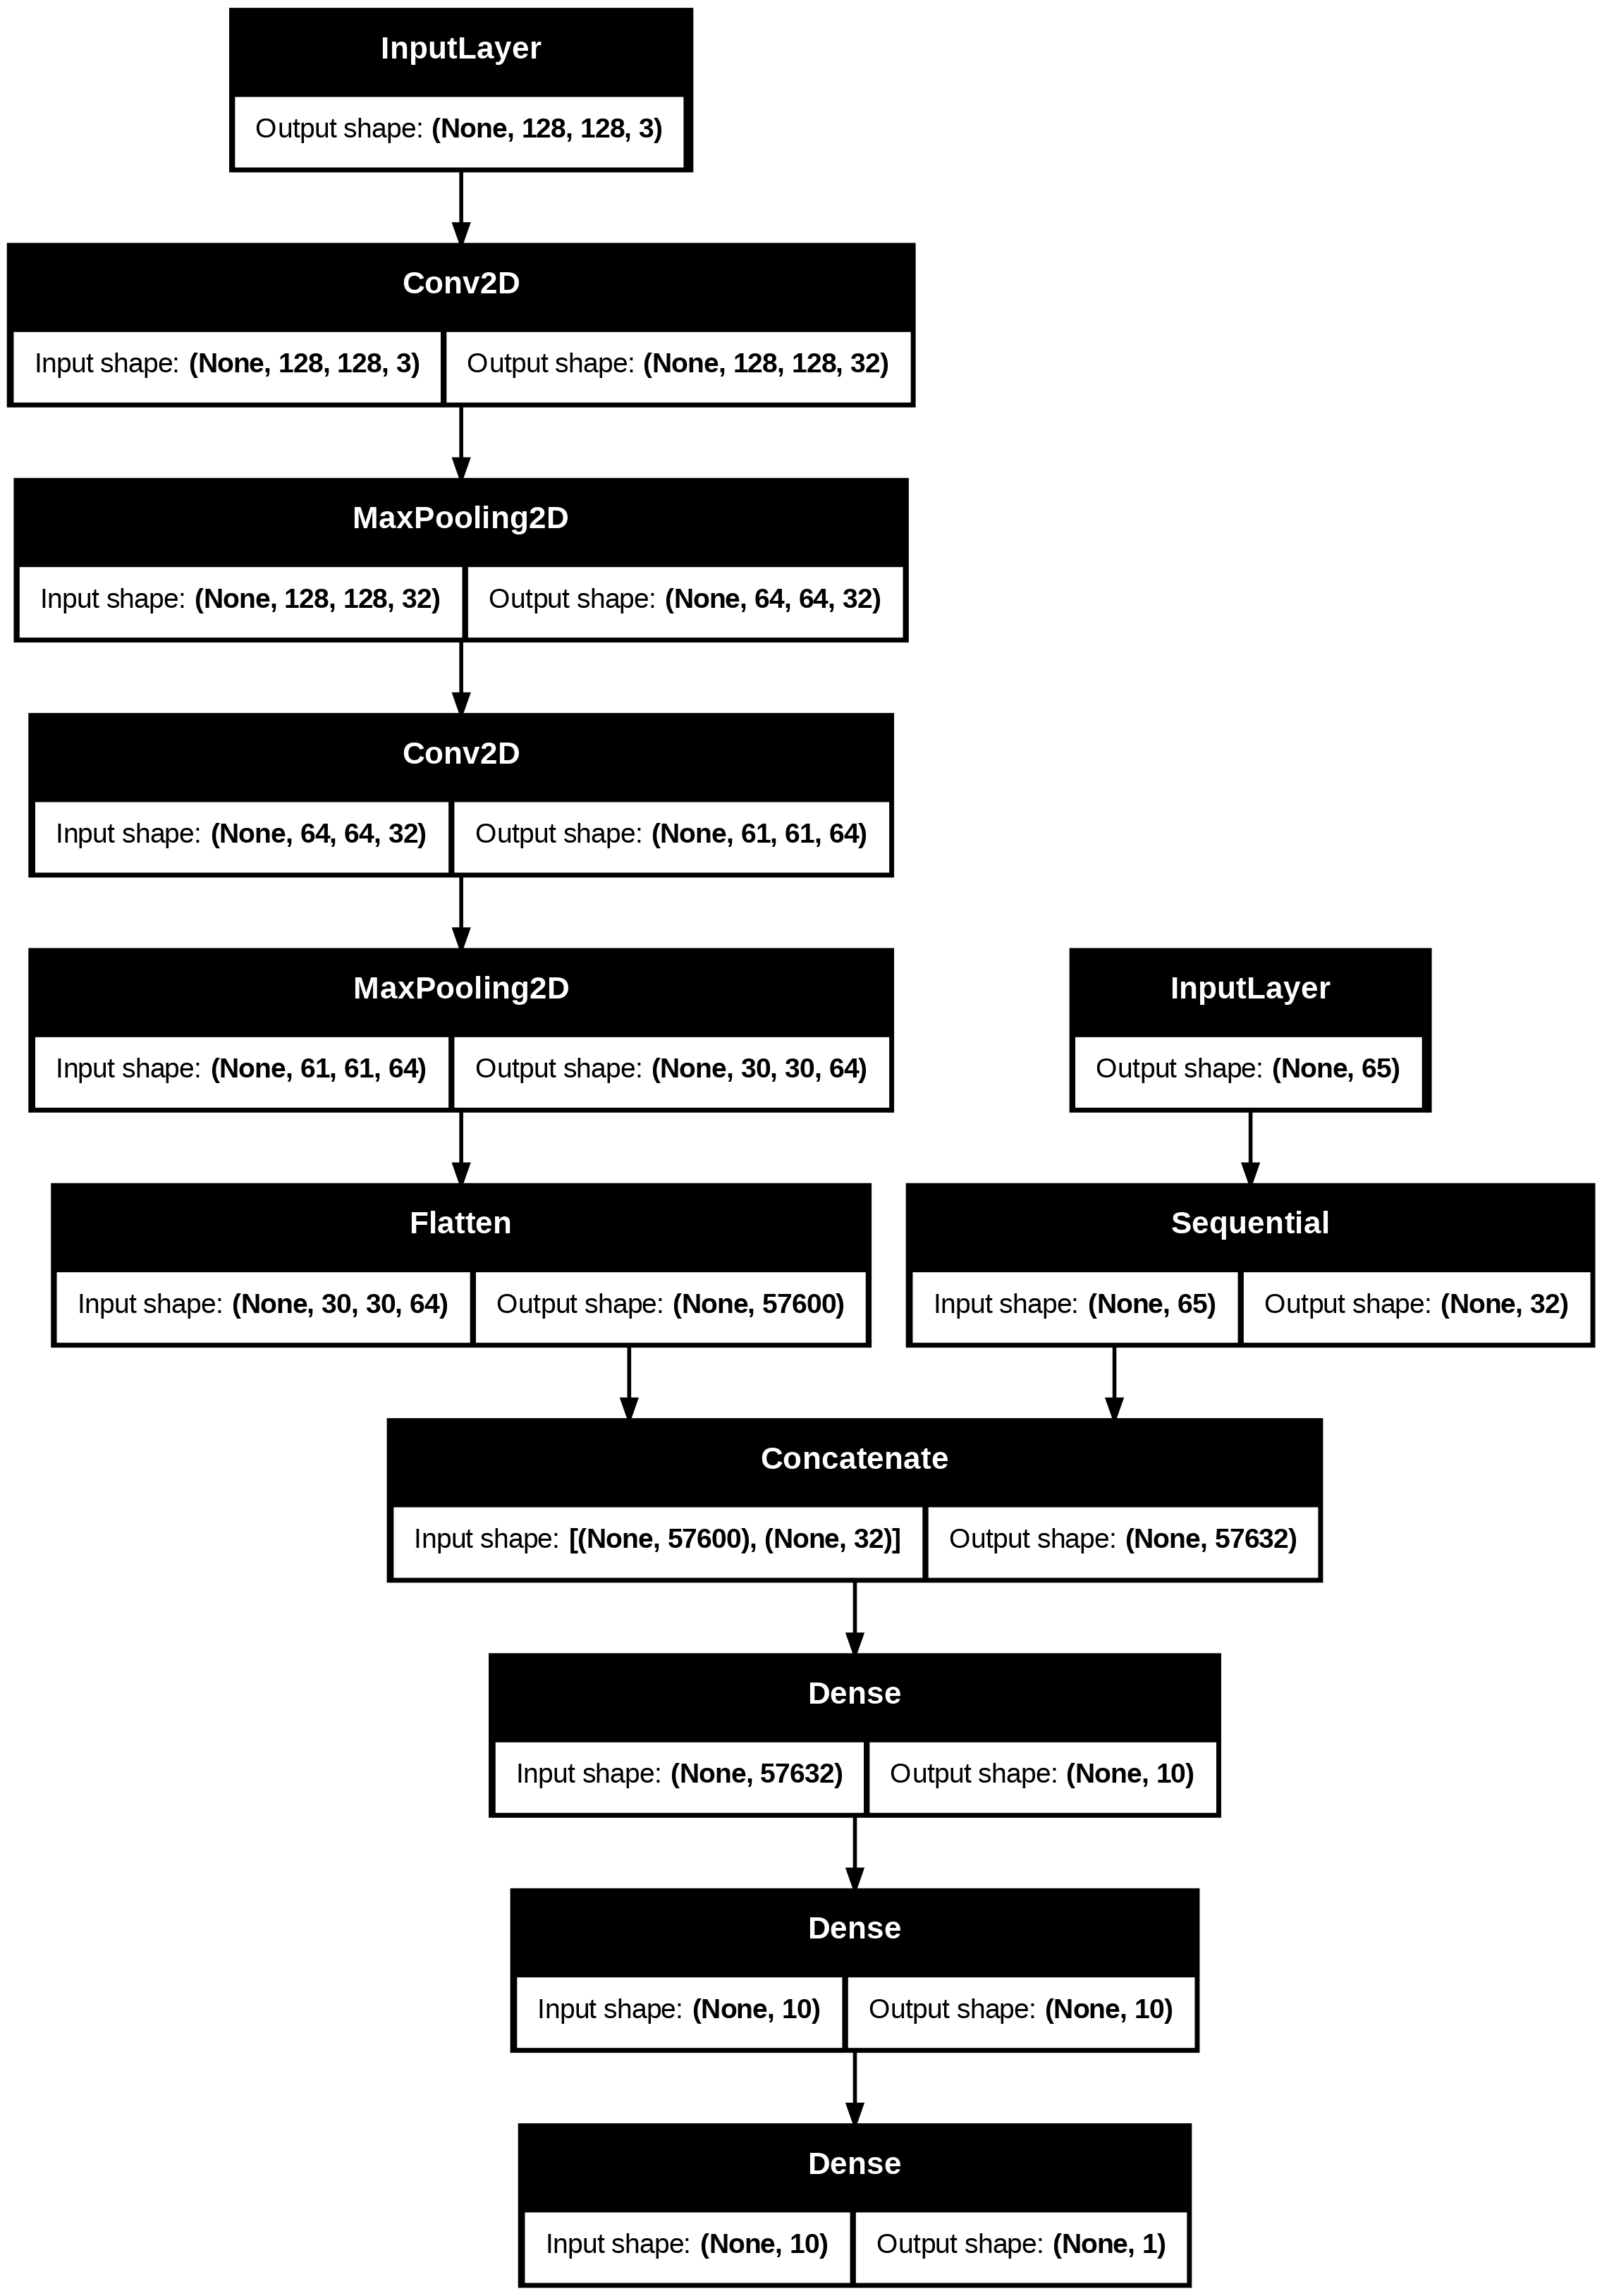

In [ ]:
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

#Model Compile/Fit

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

#input = (image, text)
model.fit([img_train, x_train], y_train, validation_data=([img_test, x_test], y_test), callbacks=[monitor], batch_size=8, verbose=2,epochs=100)

Epoch 1/100
43/43 - 15s - 342ms/step - loss: 132696576.0000 - val_loss: 10.1611
Epoch 2/100
43/43 - 20s - 465ms/step - loss: 4.6998 - val_loss: 4.8281
Epoch 3/100
43/43 - 12s - 272ms/step - loss: 1.5093 - val_loss: 4.1035
Epoch 4/100
43/43 - 13s - 296ms/step - loss: 0.9483 - val_loss: 3.6012
Epoch 5/100
43/43 - 20s - 465ms/step - loss: 0.5054 - val_loss: 3.3987
Epoch 6/100
43/43 - 20s - 466ms/step - loss: 0.3167 - val_loss: 3.2917
Epoch 7/100
43/43 - 12s - 269ms/step - loss: 0.2132 - val_loss: 3.0521
Epoch 8/100
43/43 - 21s - 479ms/step - loss: 0.1794 - val_loss: 3.0253
Epoch 9/100
43/43 - 22s - 517ms/step - loss: 0.1697 - val_loss: 2.9531
Epoch 10/100
43/43 - 19s - 438ms/step - loss: 0.2079 - val_loss: 3.3282
Epoch 11/100
43/43 - 19s - 453ms/step - loss: 0.1907 - val_loss: 3.1877
Epoch 12/100
43/43 - 21s - 493ms/step - loss: 0.1735 - val_loss: 3.2060
Epoch 13/100
43/43 - 12s - 269ms/step - loss: 0.1577 - val_loss: 3.1204
Epoch 14/100
43/43 - 12s - 272ms/step - loss: 0.1884 - val_loss:

# Model Prediction

In [ ]:
from sklearn import metrics

# Predict
pred = model.predict([img_test, x_test])

# Measure MSE error.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (MSE): {}".format(score))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step
Final score (MSE): 1.7652705907821655


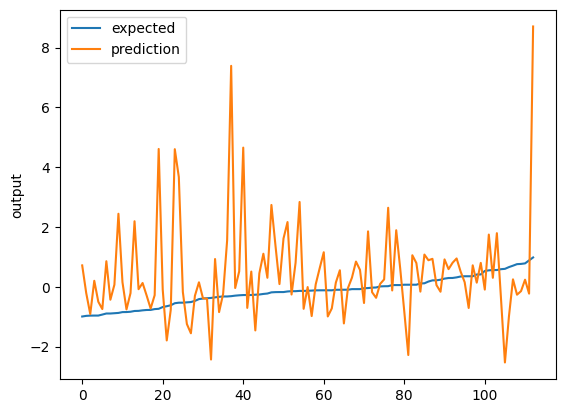

In [ ]:
# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)